In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [6]:
df = pd.read_csv('/Users/suraj/Documents/EdgeAI_Thermostat/Dataset_v1.0.csv')
df.head()

,timestamp,San Francisco Temperature,San Francisco Relative Humidity
0,0,47.062805,93
1,100,46.396810,94
2,200,45.982807,94
3,300,45.586807,94
4,400,45.316807,95


In [7]:
df.isna().sum()

timestamp                          0
San Francisco Temperature          0
San Francisco Relative Humidity    0
dtype: int64

In [8]:
train_dataset = df.sample(frac=0.8, random_state=0)
test_dataset = df.drop(train_dataset.index)

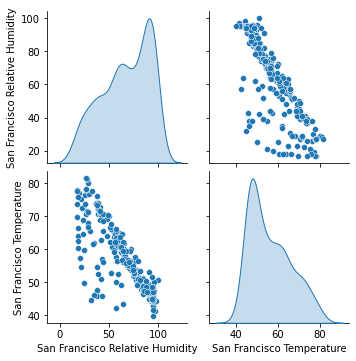

In [9]:
sns.pairplot(train_dataset[['San Francisco Relative Humidity', 'San Francisco Temperature']], diag_kind='kde')

In [10]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
timestamp,288.0,1172.222222,680.125470,0.00000,600.000000,1200.000000,1725.000000,2300.00000
San Francisco Temperature,288.0,56.225995,9.958759,39.79081,47.472308,53.758809,63.091806,81.60481
San Francisco Relative Humidity,288.0,66.996528,24.155203,17.00000,48.750000,70.000000,91.000000,100.00000


In [11]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('San Francisco Temperature')
test_labels = test_features.pop('San Francisco Temperature')

In [12]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[1172.222   66.997]


In [13]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[600  95]]

Normalized: [[-0.84  1.16]]


In [14]:
humidity = np.array(train_features['San Francisco Relative Humidity'])

humidity_normalizer = preprocessing.Normalization(input_shape=[1,])
humidity_normalizer.adapt(humidity)

In [15]:
# humidity_model = tf.keras.Sequential([humidity_normalizer, layers.Dense(units=1)])
# humidity_model.summary()

humidity_model = tf.keras.Sequential([normalizer, layers.Dense(units=1)])
humidity_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 1)                 3         
Total params: 8
Trainable params: 3
Non-trainable params: 5
_________________________________________________________________


In [16]:
#humidity_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')
humidity_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_absolute_error')

In [17]:
%%time
# history = humidity_model.fit(
#     train_features['San Francisco Relative Humidity'],
#     train_labels,
#     epochs=100,
#     verbose=0,
#     validation_split = 0.2)

history = humidity_model.fit(train_features, train_labels, epochs=100, verbose=0, validation_split = 0.2)

CPU times: user 5.78 s, sys: 361 ms, total: 6.14 s
Wall time: 6.48 s


In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.324427,3.545486,95
96,3.318468,3.533409,96
97,3.325009,3.533452,97
98,3.314455,3.525891,98
99,3.320728,3.521830,99


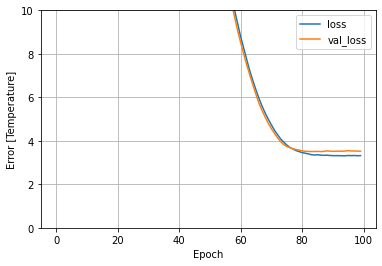

In [19]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Temperature]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [20]:
#test_results = {}
#test_results['humidity_model'] = humidity_model.evaluate(test_features['San Francisco Relative Humidity'], test_labels, verbose=0)

test_results = {}
test_results['humidity_model'] = humidity_model.evaluate(test_features, test_labels, verbose=0)

In [21]:
x = tf.linspace(0.0, 120, 251)
y = humidity_model.predict(x)

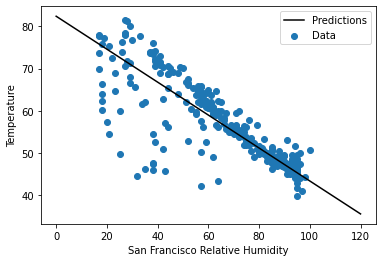

In [22]:
def plot_humidity(x, y):
  plt.scatter(train_features['San Francisco Relative Humidity'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('San Francisco Relative Humidity')
  plt.ylabel('Temperature')
  plt.legend()

plot_humidity(x, y)

In [23]:
pd.DataFrame(test_results, index=['Mean absolute error [Temperature]']).T

,Mean absolute error [Temperature]
humidity_model,4.003284


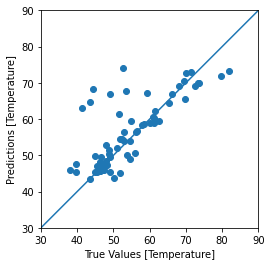

In [24]:
test_predictions = humidity_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Temperature]')
plt.ylabel('Predictions [Temperature]')
lims = [30, 90]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

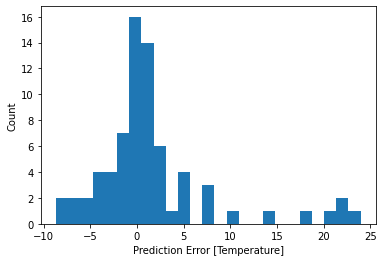

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [Temperature]')
_ = plt.ylabel('Count')